In [28]:
from __future__ import print_function, division
from collections import defaultdict, Counter
from tqdm import tqdm, tqdm_notebook
from aer import read_naacl_alignments, AERSufficientStatistics
from random import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

 20%|██████████████▋                                                           | 45849/231164 [02:52<11:39, 265.10it/s]

## Read in the data

In [11]:
english_train = 'training/hansards.36.2.e'
french_train = 'training/hansards.36.2.f'
english_val = 'validation/dev.e'
french_val = 'validation/dev.f'
fname = 'naacltest.txt'

def read_data(english_file, french_file):
    english_sentences = []
    french_sentences = []
    with open(english_file, 'r', encoding='utf8') as engf, open(french_file, 'r', encoding='utf8') as fref:
        for line in engf:
            english_sentences.append(["NULL"] + line.split())
        for line in fref:
            french_sentences.append(line.split())
    assert len(english_sentences) == len(french_sentences), 'data mismatch'
    return list(zip(english_sentences, french_sentences))

training_data = read_data(english_train, french_train)
validation_data = read_data(english_val, french_val)

# AER Cell

In [12]:
def test(path, personal_sets=None):
    from random import random
    # 1. Read in gold alignments
    gold_sets = read_naacl_alignments('validation/dev.wa.nonullalign')

    # 2. Here you would have the predictions of your own algorithm
    if personal_sets is None:
        personal_sets = read_naacl_alignments(path)
        predictions = []
        for s, p in personal_sets:
            links = set()
            for link in s:
                links.add(link)
            predictions.append(links)
    else:
        predictions=personal_sets

    # 3. Compute AER
    # first we get an object that manages sufficient statistics 
    metric = AERSufficientStatistics()
    # then we iterate over the corpus 
    for gold, pred in zip(gold_sets, predictions):
        metric.update(sure=gold[0], probable=gold[1], predicted=pred)
    # AER
    print(metric.aer())
    return metric.aer()

#hardcoded AER test for 5 iterations
# for i in range(10):
#     test('iteration'+str(i)+'.txt')

## IBM Model 1: Generative Process
Step 1: Pick an alignmet $a$ with probability  p(a|e,m) = $\frac{1}{(l+1)^m}$

Step 2: pick the French words with probability

p(f|a,e,m) = $\prod^m_{j=1} t(f_j | e_aj )$



P(f,a|e, m ) = p(a|e,m) $\times$ p(f|a,e,m)


In [13]:
def align_all(data, translate_dict, fname=None):
    """Create alignments for pairs of English and French sentences.
    Both save them as sets per sentence and pair and save to file.
    
    Args:
        validation: zipped object with pairs of e and f sentences
        translate_dict: dictionary with translation probabilities e to f
        fname: filename to save alignments in, in NAACL format

    Returns:
        list of sets
    """
    file = open(fname, 'w')
    alignments = []
    for k, (english_words, french_words) in enumerate(data):
        alignment = align(english_words, french_words, translate_dict, False)
        for pos1, pos2 in alignment:
            file.write("{} {} {}\n".format(str(k+1), str(pos1), str(pos2)))
        alignments.append(set(alignment))
    return alignments
    
def align(english_words, french_words, translate_dict, add_null=True):
    """Align one sentence pair, either with or without the NULL alignments.
    
    Args:
        english_words: list of english words
        french_words: list of french words
        translate_dict: dictionary with translation probabilities e to f
        add_null: boolean to indicate whether NULL alignments should be included

    Return:
        list of tuples
    """
    alignment = []
    for j, fword in enumerate(french_words):
        prior = 0.0
        alignment_j = 0
        for i, eword in enumerate(english_words):
            # Only include terms that are in the dictionary
            if eword in translate_dict and fword in translate_dict[eword]:
                prob = translate_dict[eword][fword]
                if prob > prior:
                    prior = prob
                    alignment_j = i
        # Add dependent on whether it's a NULL alignments
        if alignment_j != 0 or add_null:
            alignment.append((alignment_j, j + 1))
    return alignment

def log_likelihood(data, translate_dict):
    """
    Args:
        data: zipped object with pairs of e and f sentences
        translate_dict: dictionary with translation probabilities e to f

    Returns:
        float: log likelihood
    """
    log_likelihood_nonorm = 0
    log_likelihood = 0
    for e, f in data:
        alignment = align(e, f, translate_dict, True)
        prob = 0
        prob2 = 0
        for j, i in alignment:
            prob += math.log(translate_dict[e[j]][f[i-1]]) + -len(f) * np.log(len(e) + 1)
            prob2 += math.log(translate_dict[e[j]][f[i-1]])
        log_likelihood += prob
        log_likelihood_nonorm += prob2
    return log_likelihood, log_likelihood_nonorm

def initialize_t(data, uniform=True):
    """Initialise the translation probabilities.
    
    Args:
        data: list of tuples, english and french sentences
        uniform: boolean indicating initialisation type

    Returns:
        defaultdict(Counter)
    """
    co_counts = defaultdict(Counter)
    for e, f in data:
        for e_word in e:
            for f_word in f:
                if uniform:
                    co_counts[e_word][f_word] = 1
                else:
                    co_counts[e_word][f_word] = random()
    for e_word in co_counts:
        normalization_factor = sum(list(co_counts[e_word].values()))
        for f_word in co_counts[e_word]:
            co_counts[e_word][f_word] = co_counts[e_word][f_word] / normalization_factor
    return co_counts

def EM_IBM1(data, validation, max_steps=20, translate_dict=None):
    print("Initializing translation dictionary.")
    if translate_dict is None:
        translate_dict = initialize_t(data)
    for iteration in range(max_steps):
        change = False
        fname = 'iteration' + str(iteration) + '.txt'
        counts = Counter()
        co_counts = defaultdict(Counter)
        
        print("Expectation step {}".format(iteration + 1))
        for e_s, f_s in tqdm(data):
            for f in f_s:
                sum_of_probs = sum([translate_dict[e2][f] for e2 in e_s])
                for e in e_s:
                    delta = translate_dict[e][f] / sum_of_probs
                    co_counts[e][f] += delta
                    counts[e] += delta

        print("Maximisation step {}".format(iteration + 1))
        for e in co_counts:
            for f in co_counts[e]:
                new_value = co_counts[e][f] / counts[e]
                if abs(translate_dict[e][f] - new_value) > 1e-5:
                    change = True
                translate_dict[e][f] = new_value
        if not change:
            break
        #writing the iteration files in naacl for AER use
        alignments = align_all(validation, translate_dict, fname)
        ll, ll2 = log_likelihood(data, translate_dict)
        print(ll, ll2)
        test("", alignments)
    return translate_dict

translate_dict = None
translate_dict = EM_IBM1(training_data, validation_data, 10, translate_dict)

Initializing translation dictionary.
Expectation step 1


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [06:09<00:00, 625.96it/s]


Maximisation step 1
-567149814.93 -16228428.318431063
0.37238095238095237
Expectation step 2


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [05:23<00:00, 715.41it/s]


Maximisation step 2
-562486236.686 -11564850.074550282
0.33269230769230773
Expectation step 3


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [05:14<00:00, 735.43it/s]


Maximisation step 3
-560572907.897 -9651521.286288807
0.32180595581171945
Expectation step 4


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [05:04<00:00, 759.64it/s]


Maximisation step 4
-559661340.547 -8739953.935999503
0.3214629451395573
Expectation step 5


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [05:13<00:00, 737.37it/s]


Maximisation step 5
-559131866.17 -8210479.558801624
0.3214629451395573
Expectation step 6


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [04:37<00:00, 832.37it/s]


Maximisation step 6
-558789513.683 -7868127.072443296
0.32242540904716077
Expectation step 7


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [04:37<00:00, 833.70it/s]


Maximisation step 7
-558552821.055 -7631434.4442609
0.32050048123195385
Expectation step 8


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [04:32<00:00, 848.39it/s]


Maximisation step 8
-558381147.177 -7459760.566183322
0.3221153846153846
Expectation step 9


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [04:35<00:00, 837.95it/s]


Maximisation step 9
-558252234.246 -7330847.634522221
0.3221153846153846
Expectation step 10


100%|█████████████████████████████████████████████████████████████████████████| 231164/231164 [04:33<00:00, 845.21it/s]


Maximisation step 10
-558152235.423 -7230848.81215239
0.31888246628131023


In [17]:
def print_translation_probs(english_word, transdict):
    results = []
    for french_word in translate_dict[english_word]:
        results.append((translate_dict[english_word][french_word], french_word))
    results.sort(reverse=True)
    for r in results[:20]:
        print(r)
        
print_translation_probs('commissioners', translate_dict)

In [22]:
print(len(list(training_data)))
training_data[3]

231164


(['NULL', 'Tuesday', ',', 'October', '12', ',', '1999'],
 ['le', 'mardi', '12', 'octobre', '1999'])

# IBM 2

In [30]:
def EM_IBM2(data, validation, initial_translation_estimate, max_steps=3):
    translate_dict = initial_translation_estimate
    jump_dict = {}
    for iteration in range(max_steps):
        fname = 'IBM2_iteration' + str(iteration) + '.txt'
        counts = defaultdict(int)
        co_counts = defaultdict(int)
        jump_counts = defaultdict(int)
        pos_counts = 0
        for e_s,f_s in tqdm_notebook(data):
            m = len(f_s)
            l = len(e_s)
            for i, f in enumerate(f_s):
                sum_of_probs = 0
                for j, e in enumerate(e_s):
                    jump_prob = jump_dict.get(get_jump(j,i,l,m), 0.1)
                    translate_prob = translate_dict.get((e,f), 0.1)
                    sum_of_probs += jump_prob * translate_prob
                for j, e in enumerate(e_s):
                    jump_prob = jump_dict.get(get_jump(j,i,l,m), 0.1)
                    translate_prob = translate_dict.get((e,f), 0.1)
                    prob = jump_prob * translate_prob / sum_of_probs
                    co_counts[(e,f)] += prob
                    counts[e] += prob
                    jump_counts[get_jump(j,i,l,m)] += prob
                    pos_counts += prob
        for e,f in co_counts:
            translate_dict[(e,f)] = co_counts[(e, f)] / counts[e]
        for jump in jump_counts:
            jump_dict[jump] = jump_counts[jump] / pos_counts
            
        #writing the iteration files in naacl for AER use
        alignments = align_all(validation, translate_dict, fname)
        ll, ll2 = log_likelihood(data, translate_dict)
        print(ll, ll2)
        test("", alignments)
    return translate_dict, jump_dict

def get_jump(eng_pos, fre_pos, eng_len, fre_len):
    equivalent_pos = round(fre_pos * eng_len / fre_len)
    return eng_pos - equivalent_pos

# ibm2_transdict, ibm2_jumpdict = EM_IBM2(english_sentences, french_sentences, translate_dict, 2)
ibm2_transdict, ibm2_jumpdict = EM_IBM2(training_data, validation_data, translate_dict, 2)


-558152235.423 -7230848.81215239
0.31888246628131023

-558152235.423 -7230848.81215239
0.31888246628131023


(0.3232364890545953, 'le')
(0.29456213711535784, 'agriculture')
(0.14910289812294164, 'AGRICULTURE')
(0.11448242693911999, 'Agriculture')
(0.06990144893242166, 'agricole')
(0.024702958952876403, 'secteur')
(0.008593366974906362, 'agricoles')
(0.0032051947389561217, 'agriculteurs')
(0.001258794918081106, 'compte')
(0.0009618851178878523, 'domaine')
(0.0009507917947188696, 'connaissons')
(0.0007352065495309601, 'localités')
(0.0007329095065481056, 'différentes')
(0.000716043204786255, 'Saskatoon')
(0.0007101157235241055, 'réclamer')
(0.0007063810894605436, 'Winnipeg')
(0.0006791983528763362, 'organisations')
(0.0006581991551255391, 'étaient')
(0.0006481881329706883, 'actuel')
(0.0006389983553046873, 'nombre')


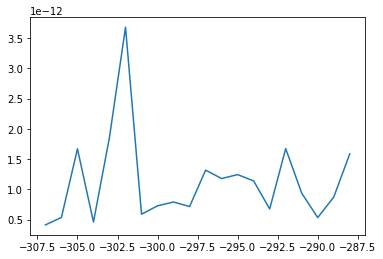

1.00000000001


In [31]:
print_translation_probs('agriculture', ibm2_transdict)
jumps = np.array(sorted(ibm2_jumpdict.items()))
plt.plot(jumps[65:85,0], jumps[65:85,1])
plt.show()
print(sum(jumps[:,1]))